In [104]:
# ============================================================
# Delhi–NCR AQI Project (2018–2023)
# Professional EDA + Modeling Pipeline (Interim Submission)
# Author: Brijesh Kumar
# ============================================================


In [105]:
# -----------------------------
# Import Libraries
# -----------------------------

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


plt.rcParams['figure.figsize'] = (6,4)

In [106]:
# -----------------------------
# Paths & configuration
# -----------------------------
#  Update this to your Excel file path
DATA_PATH = Path(r"E:\DBA_WALSH\DBA_AQI_Project\data\Master_AQI_2018_2023.xlsx")  # <-- change filename if different

#  Output directory for plots and tables
OUT_DIR = Path(r"E:\DBA_WALSH\DBA_AQI_Project\outputs")
PLOT_DIR = OUT_DIR / "plots"
TABLE_DIR = OUT_DIR / "tables"
PLOT_DIR.mkdir(parents=True, exist_ok=True)
TABLE_DIR.mkdir(parents=True, exist_ok=True)
ALPHA = 0.05  # significance level used in report

print("Data path:", DATA_PATH)
print("Output dir:", OUT_DIR)

Data path: E:\DBA_WALSH\DBA_AQI_Project\data\Master_AQI_2018_2023.xlsx
Output dir: E:\DBA_WALSH\DBA_AQI_Project\outputs


In [107]:
df = pd.read_excel(DATA_PATH)

In [108]:
# Quick sanity checks
print("\nData shape:", df.shape)
print(df.info())
print(df.head())


Data shape: (10924, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10924 entries, 0 to 10923
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              10924 non-null  datetime64[ns]
 1   Station           10924 non-null  object        
 2   Daily_MAX_AQI     10924 non-null  int64         
 3   Daily_MEDIAN_AQI  10437 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 341.5+ KB
None
        Date   Station  Daily_MAX_AQI  Daily_MEDIAN_AQI
0 2018-01-01  Sirifort            500             500.0
1 2018-01-02  Sirifort            500             497.0
2 2018-01-03  Sirifort            500             370.0
3 2018-01-04  Sirifort            500             416.0
4 2018-01-05  Sirifort            500             408.0


In [109]:
null_value_count = df.isnull().sum()
null_value_percent = (df.isnull().sum() / len(df)) * 100
print("Count of NULL values   : ", null_value_count)
print()
print("Percent of NULL Values : ", null_value_percent)

Count of NULL values   :  Date                  0
Station               0
Daily_MAX_AQI         0
Daily_MEDIAN_AQI    487
dtype: int64

Percent of NULL Values :  Date                0.000000
Station             0.000000
Daily_MAX_AQI       0.000000
Daily_MEDIAN_AQI    4.458074
dtype: float64


In [110]:
# Create additional column for meaningful analysis 
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.day_name()

df.head()

,Date,Station,Daily_MAX_AQI,Daily_MEDIAN_AQI,Year,Month,Day,Weekday
0,2018-01-01,Sirifort,500,500.0,2018,1,1,Monday
1,2018-01-02,Sirifort,500,497.0,2018,1,2,Tuesday
2,2018-01-03,Sirifort,500,370.0,2018,1,3,Wednesday
3,2018-01-04,Sirifort,500,416.0,2018,1,4,Thursday
4,2018-01-05,Sirifort,500,408.0,2018,1,5,Friday


In [111]:
df[df['Daily_MAX_AQI'] == 0]['Station'].value_counts()
df[df['Daily_MAX_AQI'] == 0].shape


(488, 8)

In [112]:
df[df['Daily_MAX_AQI'] == 0].shape

(488, 8)

In [113]:
# 0 values are not valid values. Difficult to think of 0 as AQI values. It will be replaced by NULL
df['Daily_MAX_AQI'] = df['Daily_MAX_AQI'].replace(0, np.nan)


In [114]:
null_values = df['Daily_MAX_AQI'].isnull().sum()
print(f"Null Values converted from 0 : {null_values}")
null_percent= (df['Daily_MAX_AQI'].isnull().sum() / len(df)) * 100
print(f"Missing percentage: {null_percent:.3f}%")

Null Values converted from 0 : 488
Missing percentage: 4.467%


“A total of 488 observations (4.47%) recorded AQI values of 0. Given that an AQI of zero is not meteorologically plausible for Delhi, these values were treated as missing and recoded as NaN for subsequent analysis.”

In [115]:
#Category-Based AQI Analysis (Policy Relevant)
def categorize_aqi(aqi):
    if pd.isna(aqi):
        return np.nan
    elif aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Satisfactory"
    elif aqi <= 200:
        return "Moderate"
    elif aqi <= 300:
        return "Poor"
    elif aqi <= 400:
        return "Very Poor"
    else:
        return "Severe"

df['AQI_Category'] = df['Daily_MAX_AQI'].apply(categorize_aqi)


In [116]:
df['AQI_Category'].value_counts(normalize=True) * 100


AQI_Category
Severe          37.476044
Very Poor       24.971253
Moderate        20.927558
Poor            12.801840
Satisfactory     3.689153
Good             0.134151
Name: proportion, dtype: float64

In [117]:
#Seasonality Significance Test (ANOVA by Month)

import scipy.stats as stats

# Remove NaN first
df_clean = df.dropna(subset=['Daily_MAX_AQI'])

groups = [group['Daily_MAX_AQI'].values 
          for name, group in df_clean.groupby('Month')]

f_stat, p_value = stats.f_oneway(*groups)

print("f-state :",f_stat)
print("p-value : ",p_value)


f-state : 856.8568378600701
p-value :  0.0


In [118]:
#Please run the COVID structural break t-test:
pre_covid = df_clean[df_clean['Year'].isin([2018, 2019])]['Daily_MAX_AQI']
covid_year = df_clean[df_clean['Year'] == 2020]['Daily_MAX_AQI']

t_stat, p_value = stats.ttest_ind(pre_covid, covid_year, equal_var=False)

t_stat, p_value
print("f-state :",f_stat)
print("p-value : ",p_value)



f-state : 856.8568378600701
p-value :  1.5388601484032965e-18


In [119]:
def finalize_ax(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, axis="y", alpha=0.25)
    ax.grid(False, axis="x")


In [120]:
# -----------------------------
# 1) Basic setup (safe defaults)
# -----------------------------
plt.rcParams.update({
    "figure.dpi": 110,
    "savefig.dpi": 300,
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "legend.fontsize": 10,
    "axes.grid": True,
    "grid.alpha": 0.25,
})

# Ensure Date is datetime and time features exist
df = df.copy()
df["Date"] = pd.to_datetime(df["Date"])
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month

# Month names ordered
month_order = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
df["MonthName"] = df["Date"].dt.strftime("%b")
df["MonthName"] = pd.Categorical(df["MonthName"], categories=month_order, ordered=True)

# Output folder
PLOT_DIR = r"E:\DBA_WALSH\DBA_AQI_Project\outputs\plots"
os.makedirs(PLOT_DIR, exist_ok=True)

def _clean_axes(ax):
    """Minimal, inline styling (not a helper you must call separately)."""
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, axis="y", alpha=0.25)
    ax.grid(False, axis="x")

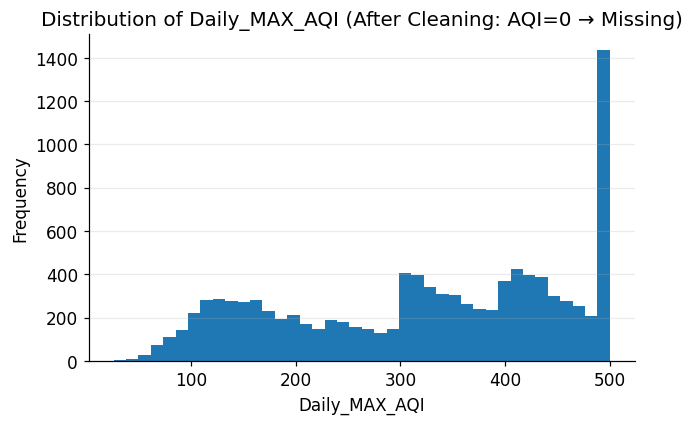

In [121]:
# ======================================================
# FIGURE 1 — Distribution (Histogram) after cleaning
# ======================================================
fig, ax = plt.subplots(figsize=(6, 4))
x = df["Daily_MAX_AQI"].dropna()
ax.hist(x, bins=40)
ax.set_title("Distribution of Daily_MAX_AQI (After Cleaning: AQI=0 → Missing)")
ax.set_xlabel("Daily_MAX_AQI")
ax.set_ylabel("Frequency")
_clean_axes(ax)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "Fig1_Distribution_Daily_MAX_AQI.png"), dpi=300, bbox_inches="tight")
plt.show()

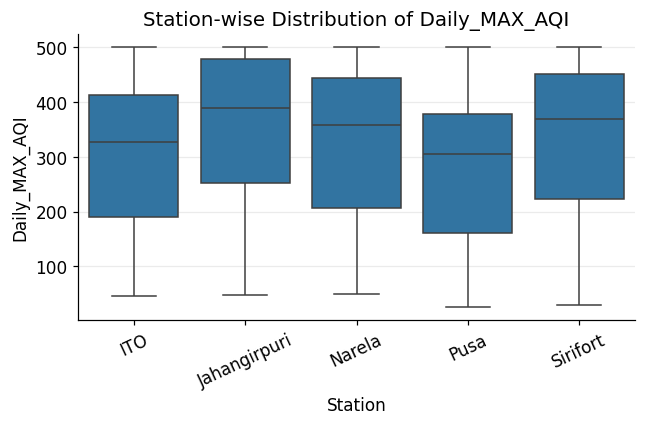

In [122]:
# ======================================================
# FIGURE 2 — Station-wise distribution (Boxplot)
# ======================================================
fig, ax = plt.subplots(figsize=(6, 4))
station_order = sorted(df["Station"].dropna().unique())

sns.boxplot(data=df, x="Station", y="Daily_MAX_AQI", order=station_order, ax=ax)
ax.set_title("Station-wise Distribution of Daily_MAX_AQI")
ax.set_xlabel("Station")
ax.set_ylabel("Daily_MAX_AQI")
ax.tick_params(axis="x", rotation=25)
_clean_axes(ax)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "Fig2_Boxplot_Stationwise_AQI.png"), dpi=300, bbox_inches="tight")
plt.show()

Station-wise analysis of Daily_MAX_AQI reveals substantial spatial variability across Delhi monitoring stations. Jahangirpuri exhibits the highest median AQI levels, indicating persistently elevated pollution exposure. While Pusa demonstrates comparatively lower median values, all stations experience extreme pollution episodes reaching the regulatory ceiling of AQI = 500. The wide interquartile ranges observed across stations suggest significant seasonal volatility, particularly during winter months.

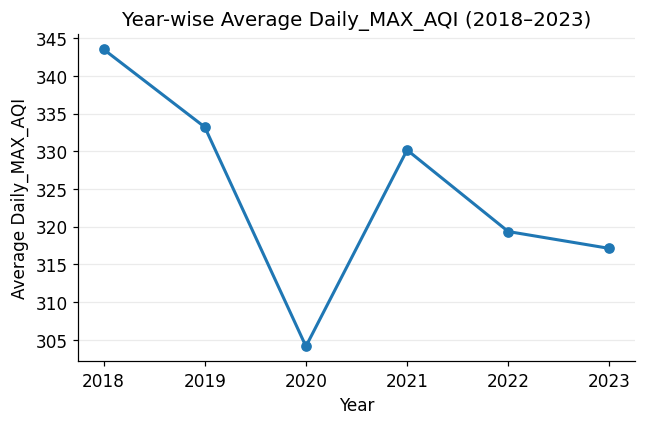

In [123]:
# ======================================================
# FIGURE 3 — Year-wise mean AQI (Line plot)
# ======================================================
yearly = (df.groupby("Year")["Daily_MAX_AQI"].mean().sort_index())

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(yearly.index, yearly.values, marker="o", linewidth=2)
ax.set_title("Year-wise Average Daily_MAX_AQI (2018–2023)")
ax.set_xlabel("Year")
ax.set_ylabel("Average Daily_MAX_AQI")
ax.set_xticks(yearly.index)
_clean_axes(ax)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "Fig3_Yearwise_Average_AQI.png"), dpi=300, bbox_inches="tight")
plt.show()

Year-wise analysis indicates a pronounced decline in average Daily_MAX_AQI during 2020, coinciding with nationwide COVID-19 lockdown measures. The subsequent rebound in 2021 reflects the resumption of economic and transportation activities. While pollution levels in 2022 and 2023 remain elevated, they do not return to the pre-pandemic peak observed in 2018, suggesting partial structural or policy-induced adjustments.

C:\Users\BRIJESH\AppData\Local\Temp\ipykernel_5680\1194094520.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly = (df.groupby("MonthName")["Daily_MAX_AQI"]


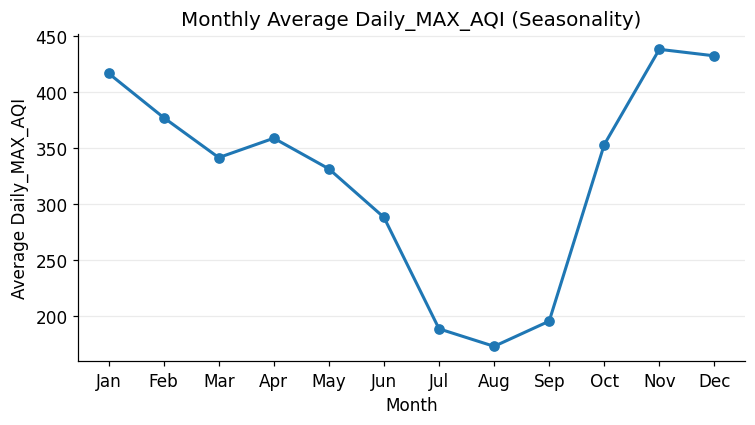

In [124]:
# ======================================================
# FIGURE 4 — Monthly mean AQI (Month names)
# ======================================================
monthly = (df.groupby("MonthName")["Daily_MAX_AQI"]
           .mean()
           .reindex(month_order))

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot([str(m) for m in monthly.index], monthly.values, marker="o", linewidth=2)
ax.set_title("Monthly Average Daily_MAX_AQI (Seasonality)")
ax.set_xlabel("Month")
ax.set_ylabel("Average Daily_MAX_AQI")
_clean_axes(ax)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "Fig4_Monthly_Average_AQI.png"), dpi=300, bbox_inches="tight")
plt.show()

Monthly analysis reveals pronounced seasonal variation in AQI levels. Pollution peaks during November–January, with average AQI exceeding 430 in November, while monsoon months (July–August) exhibit the lowest values, dropping below 200. This pattern highlights the combined impact of meteorological conditions, agricultural burning, and urban emissions on seasonal pollution dynamics in Delhi.

C:\Users\BRIJESH\AppData\Local\Temp\ipykernel_5680\3421514814.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_station = (df.groupby(["MonthName", "Station"])["Daily_MAX_AQI"]


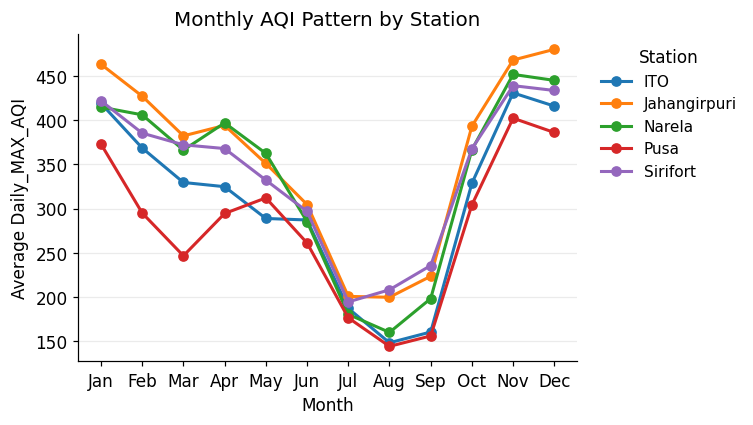

In [125]:
# ======================================================
# FIGURE 5 — Monthly pattern by station 
# ======================================================
monthly_station = (df.groupby(["MonthName", "Station"])["Daily_MAX_AQI"]
                   .mean()
                   .unstack("Station")
                   .reindex(month_order))

# stable station order in legend
monthly_station = monthly_station[sorted(monthly_station.columns)]

fig, ax = plt.subplots(figsize=(7, 4))
for st in monthly_station.columns:
    ax.plot(month_order, monthly_station[st].values, marker="o", linewidth=2, label=st)

ax.set_title("Monthly AQI Pattern by Station")
ax.set_xlabel("Month")
ax.set_ylabel("Average Daily_MAX_AQI")
ax.legend(title="Station", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
_clean_axes(ax)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "Fig5_Monthly_AQI_By_Station.png"), dpi=300, bbox_inches="tight")
plt.show()

The monthly station-wise analysis demonstrates a consistent seasonal structure across all monitoring locations. AQI levels decline sharply during monsoon months (July–August) and escalate dramatically beginning in October, peaking in November–December. Jahangirpuri consistently records the highest pollution levels, while Pusa remains relatively lower but still experiences severe winter spikes. This uniform seasonal pattern across geographically distinct stations suggests dominant meteorological drivers rather than isolated localized emission sources.

A1) Prep + Train/Test split (time-aware split)

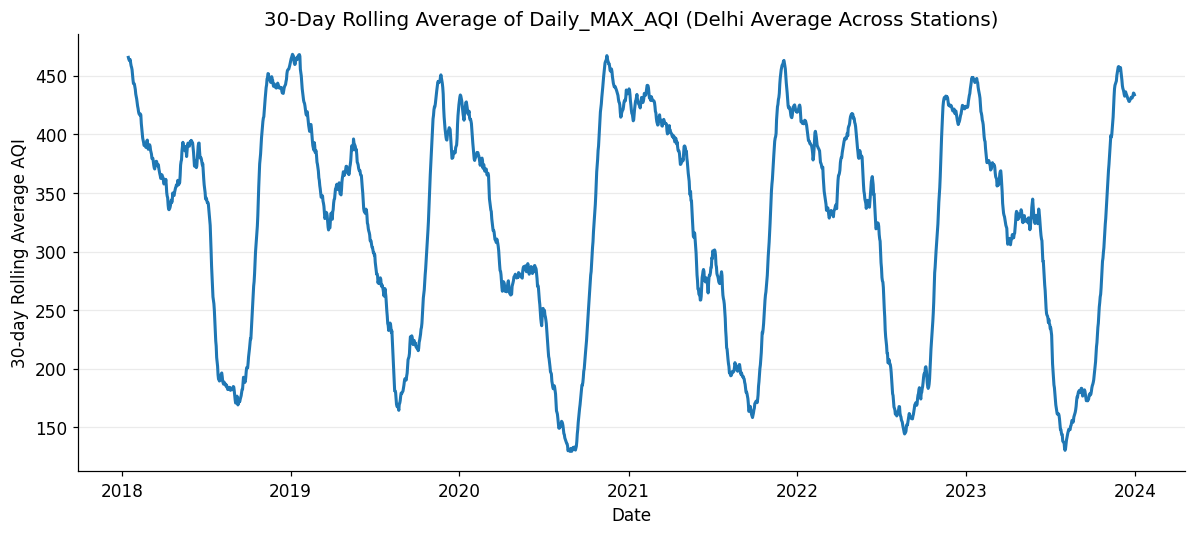

In [126]:
# ======================================================
# FIGURE 6 — 30-day rolling average (Delhi mean)
# ======================================================
daily_mean = (df.groupby("Date")["Daily_MAX_AQI"].mean().sort_index())
rolling_30 = daily_mean.rolling(window=30, min_periods=15).mean()

fig, ax = plt.subplots(figsize=(11, 5))
ax.plot(rolling_30.index, rolling_30.values, linewidth=2)
ax.set_title("30-Day Rolling Average of Daily_MAX_AQI (Delhi Average Across Stations)")
ax.set_xlabel("Date")
ax.set_ylabel("30-day Rolling Average AQI")
_clean_axes(ax)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "Fig6_Rolling30_AQI.png"), dpi=300, bbox_inches="tight")
plt.show()

The 30-day rolling average analysis reveals pronounced cyclical behavior in Delhi’s AQI levels, characterized by recurring winter peaks and monsoon troughs. A significant structural deviation is observed in 2020, corresponding with pandemic-related mobility restrictions. However, post-2020 recovery trends indicate a return to pre-pandemic pollution levels, suggesting that the temporary reduction was not structurally sustained. The magnitude of seasonal amplitude (~300 AQI units) highlights substantial intra-annual volatility and reinforces the need for seasonally adaptive mitigation strategies.

In [127]:

# 1) Clean modeling dataset
df_model = df.dropna(subset=["Daily_MAX_AQI"]).copy()
df_model["Date"] = pd.to_datetime(df_model["Date"])
df_model["Year"] = df_model["Date"].dt.year
df_model["Month"] = df_model["Date"].dt.month

# (Optional but recommended) cyclical encoding for Month
df_model["Month_sin"] = np.sin(2 * np.pi * df_model["Month"] / 12)
df_model["Month_cos"] = np.cos(2 * np.pi * df_model["Month"] / 12)

# Sort by time for time-aware split
df_model = df_model.sort_values("Date")

# 2) Features & target
target = "Daily_MAX_AQI"
X = df_model[["Year", "Month_sin", "Month_cos", "Station"]]
y = df_model[target]

# 3) Train/Test split by time (last 20% as test)
split_idx = int(len(df_model) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Train rows:", len(X_train), "Test rows:", len(X_test))
print("Train date range:", df_model["Date"].iloc[:split_idx].min(), "to", df_model["Date"].iloc[:split_idx].max())
print("Test date range :", df_model["Date"].iloc[split_idx:].min(), "to", df_model["Date"].iloc[split_idx:].max())


Train rows: 8348 Test rows: 2088
Train date range: 2018-01-01 00:00:00 to 2022-10-19 00:00:00
Test date range : 2022-10-19 00:00:00 to 2023-12-31 00:00:00


A2) Define preprocessing (one-hot encode Station)

In [128]:
categorical_features = ["Station"]
numeric_features = ["Year", "Month_sin", "Month_cos"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features),
    ]
)


A3) Baselines + Random Forest model

In [129]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# -------------------------
# Helper: evaluate a model
# -------------------------
def eval_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    mse = mean_squared_error(y_test, pred)  # compatible with older sklearn
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)

    return {"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2}, pred


# -------------------------
# Preprocess: One-hot encode Station, pass numeric through
# Assumes you already created:
# X_train, X_test, y_train, y_test
# with columns: ["Year", "Month_sin", "Month_cos", "Station"]
# -------------------------
categorical_features = ["Station"]
numeric_features = ["Year", "Month_sin", "Month_cos"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features),
    ]
)

# -------------------------
# Models
# -------------------------
# 1) Baseline: predict mean
dummy = Pipeline(steps=[
    ("prep", preprocess),
    ("model", DummyRegressor(strategy="mean"))
])

# 2) Linear regression benchmark
linreg = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LinearRegression())
])

# 3) Random Forest (fast + strong)
rf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=400,
        random_state=42,
        n_jobs=-1,
        min_samples_leaf=5
    ))
])

# -------------------------
# Train + Evaluate
# -------------------------
results = []
preds = {}

r, p = eval_model("Baseline (Mean)", dummy, X_train, y_train, X_test, y_test)
results.append(r); preds["Baseline (Mean)"] = p

r, p = eval_model("Linear Regression", linreg, X_train, y_train, X_test, y_test)
results.append(r); preds["Linear Regression"] = p

r, p = eval_model("Random Forest", rf, X_train, y_train, X_test, y_test)
results.append(r); preds["Random Forest"] = p

results_df = pd.DataFrame(results).sort_values("RMSE").reset_index(drop=True)
results_df


,Model,RMSE,MAE,R2
0,Random Forest,95.619148,73.917187,0.453290
1,Linear Regression,97.821941,80.715565,0.427810
2,Baseline (Mean),130.121651,113.201868,-0.012434


A4) Feature importance (Random Forest)

In [130]:
import matplotlib.pyplot as plt

# Fit RF on train
rf.fit(X_train, y_train)

# Get feature names after preprocessing
ohe = rf.named_steps["prep"].named_transformers_["cat"]
station_feature_names = list(ohe.get_feature_names_out(["Station"]))
feature_names = station_feature_names + numeric_features

importances = rf.named_steps["model"].feature_importances_
fi = pd.DataFrame({"Feature": feature_names, "Importance": importances}).sort_values("Importance", ascending=False)

fi.head(12)


,Feature,Importance
7,Month_cos,0.481338
6,Month_sin,0.275087
5,Year,0.128915
3,Station_Pusa,0.047213
4,Station_Sirifort,0.020642
0,Station_ITO,0.019762
1,Station_Jahangirpuri,0.018050
2,Station_Narela,0.008994


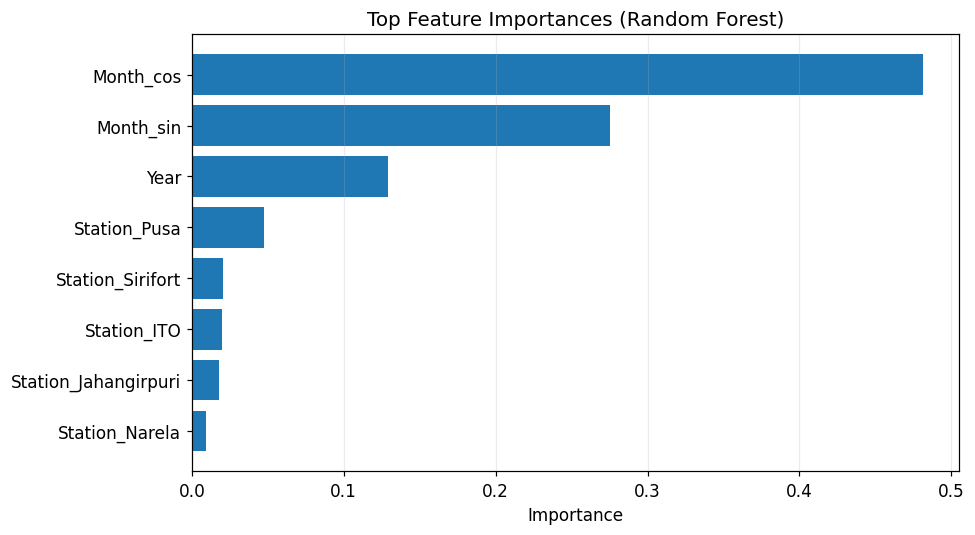

In [131]:
top_n = 10
fi_top = fi.head(top_n).iloc[::-1]  # reverse for horizontal plot

fig, ax = plt.subplots(figsize=(9, 5))
ax.barh(fi_top["Feature"], fi_top["Importance"])
ax.set_title("Top Feature Importances (Random Forest)")
ax.set_xlabel("Importance")
ax.set_ylabel("")
ax.grid(True, axis="x", alpha=0.25)
ax.grid(False, axis="y")
plt.tight_layout()
plt.show()


A5) Residual diagnostics (quick + useful)

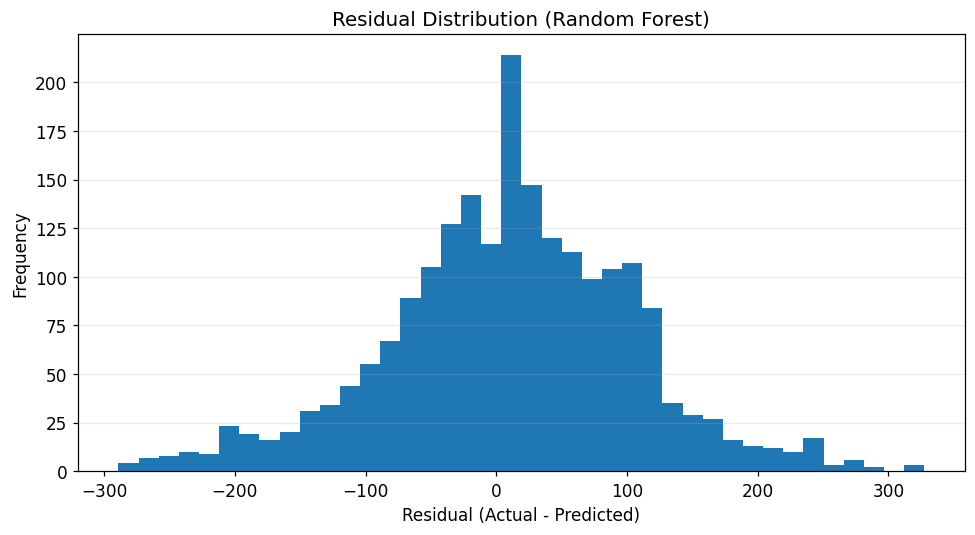

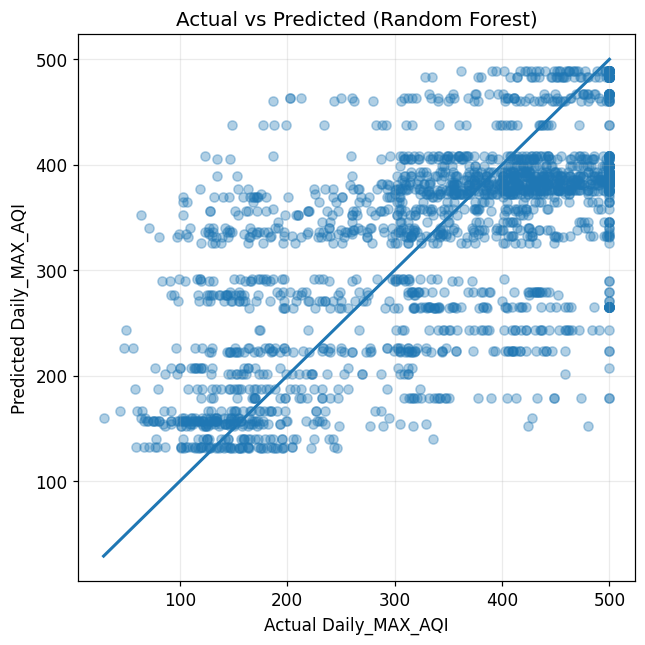

In [132]:
y_pred = preds["Random Forest"]
residuals = y_test.values - y_pred

# Residual distribution
fig, ax = plt.subplots(figsize=(9, 5))
ax.hist(residuals, bins=40)
ax.set_title("Residual Distribution (Random Forest)")
ax.set_xlabel("Residual (Actual - Predicted)")
ax.set_ylabel("Frequency")
ax.grid(True, axis="y", alpha=0.25)
ax.grid(False, axis="x")
plt.tight_layout()
plt.show()

# Actual vs Predicted
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_test, y_pred, alpha=0.35)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linewidth=2)
ax.set_title("Actual vs Predicted (Random Forest)")
ax.set_xlabel("Actual Daily_MAX_AQI")
ax.set_ylabel("Predicted Daily_MAX_AQI")
ax.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()
